# Imaging at large angles

In [1]:
from pylab import *
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
import astropy.units as units
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
import time


%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
ls /data/craco/ban115/test_data/

ddgrid/                       frb_d0_t3_a1_sninf_lm00/      nant20@
frb_d0_t0_a1_sn10_lm00/       frb_d0_t4_a1_sninf_lm00/      nant3/
frb_d0_t0_a1_sninf_lm00/      frb_d0_t9_a1_sninf_lm00/      nant30/
frb_d0_t0_a1_sninf_lm100200/  frb_d2_t0_a1_sninf_lm00/      nant36/
frb_d0_t0_a2_sninf_lm00/      frb_d2_t4_a1_sn10_lm300400/   old_tranpose/
frb_d0_t1_a1_sninf_lm00/      frb_d2_t4_a1_sninf_lm300400/  transpose_31204/
frb_d0_t2_a1_sninf_lm00/      frb_d3_t7_a1_sninf_lm00/


In [3]:
#fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
fits = '/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits'

# PSR B1933+16 data
fits = '/data/craco/ban115/craco-python/notebooks/data/SB049048v2/cap_spi16_bm0_a1-12_k1-6_ps_tsoff/results/b00.uvfits'

values = craco.search_pipeline.get_parser().parse_args([])
print(values)
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --max-nbl 465 ")

Namespace(boxcar_weight='sum', calibration=None, cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_input=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=0, flag_ants=None, flag_chans=None, injection_file=None, input_scale=1.0, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', phase_center_filterbank=None, print_dm0_stats=False, run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, skip_blocks=0, subtract=True, target_input_rms=512, threshold=10.0, uv=None, verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')
parsing values --ndm 2 --max-nbl 465 


/data/craco/ban115/craft-github/src/craft/uvfits.py:195: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'CRACO_B1933+16_beam0', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 47.999999999999815, 293.94875, 16.277786111111123, 2000.0, 293.94875, 16.277786111111123, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=258.0 1-2 uvpix=(255, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=516.0 2-4 uvpix=(0, 254)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0

Upper registers [(2, 1), (3, 1), (18, 1), (19, 1), (46, 1), (47, 1), (48, 1), (49, 1), (213, 1), (214, 1), (215, 1), (216, 1), (233, 1), (234, 1), (239, 1), (240, 1), (246, 1), (253, 1), (254, 1), (255, 1), (10, 2), (11, 2), (19, 2), (20, 2), (21, 2), (24, 2), (25, 2), (29, 2), (30, 2), (31, 2), (49, 2), (50, 2)]
Lower registers [(1, 2), (2, 5), (2, 7), (1, 10), (5, 10), (9, 10), (1, 11), (3, 11), (6, 11), (2, 12), (3, 12), (6, 12), (2, 13), (3, 13), (4, 13), (6, 13), (8, 13), (9, 13), (10, 13), (3, 14), (4, 14), (6, 14), (9, 14), (10, 14), (11, 14), (12, 14), (13, 14), (1, 15), (5, 15), (9, 15), (11, 15), (13, 15)]


In [4]:
def pointsource(amp, lm, plan, noiseamp=0):
    '''
    Returns simulted visibilities for a point source with given amplitude at given value of lm =(l, m) in radians
    offset from the phase center
        
    :amp: amplitude
    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
    :plan: craco_plan to get all the goodies like UVWs and stuff from
    :noiseamp: add nois with tgiven ampliutude
    :returns: np.array of complex dtype with shape (nbl, nchan)
    '''
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        w = uvw_sec[2]*freqs

        # TMS equation 3.7 - don't include 1/sqrt(1 - l*l - m*m) denomiator term for point sources#
        # TMS has a minus sign
        # Andre Offringa's simulator has a plus sign
        # go figure?
        # Without the minus sign also matches miriad
        vis = amp*np.exp(2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if noiseamp > 0:
            vishape = vis.shape
            noise = noiseamp*(np.random.randn(*vishape) + 1j*np.random.randn(*vishape))
            vis += noise

        dout[ibl, :] = vis

    return dout

In [5]:
plan.freqs = np.around(plan.freqs, -5)
plan.freqs

array([7.44e+08, 7.45e+08, 7.46e+08, 7.47e+08, 7.48e+08, 7.49e+08,
       7.50e+08, 7.51e+08, 7.52e+08, 7.53e+08, 7.54e+08, 7.55e+08,
       7.56e+08, 7.57e+08, 7.58e+08, 7.59e+08, 7.60e+08, 7.61e+08,
       7.62e+08, 7.63e+08, 7.64e+08, 7.65e+08, 7.66e+08, 7.67e+08,
       7.68e+08, 7.69e+08, 7.70e+08, 7.71e+08, 7.72e+08, 7.73e+08,
       7.74e+08, 7.75e+08, 7.76e+08, 7.77e+08, 7.78e+08, 7.79e+08,
       7.80e+08, 7.81e+08, 7.82e+08, 7.83e+08, 7.84e+08, 7.85e+08,
       7.86e+08, 7.87e+08, 7.88e+08, 7.89e+08, 7.90e+08, 7.91e+08])

In [6]:
lm = (0,0.1)
# The fits files with lm100200 has l,m offsets of 100,200 arcseconds respecitvely. Let's see if we can reproduce it.
lmarcsec = np.array((100,200))
lm = np.sin(np.radians(lmarcsec/3600))
#lm=(0.01,0.02)
#lm = np.sin(np.radians([0.5,0.5]))
vissim = pointsource(1, lm, plan)
print('lm', lm)

lm [0.00048481 0.00096963]


<IPython.core.display.Javascript object>


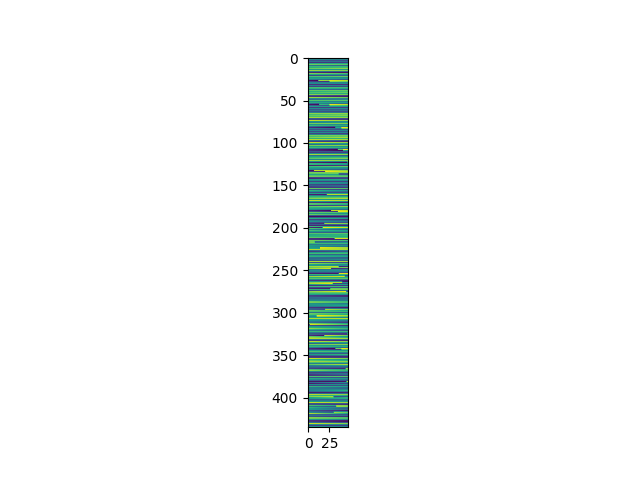

In [7]:
figure()
imshow(np.angle(vissim))

In [8]:
uvws = []
freqs = plan.freqs

for ibl, blid in enumerate(plan.baseline_order):       
    # baselines in seconds
    uvw_sec = np.array(plan.baselines[blid][:3])

    # convert UVW coordinates to wavelegths
    u = uvw_sec[0]*freqs
    v = uvw_sec[1]*freqs
    w = uvw_sec[2]*freqs
    uvws.append((u,v,w))
    
uvws = np.array(uvws)
uvws.shape

(435, 3, 48)

<IPython.core.display.Javascript object>


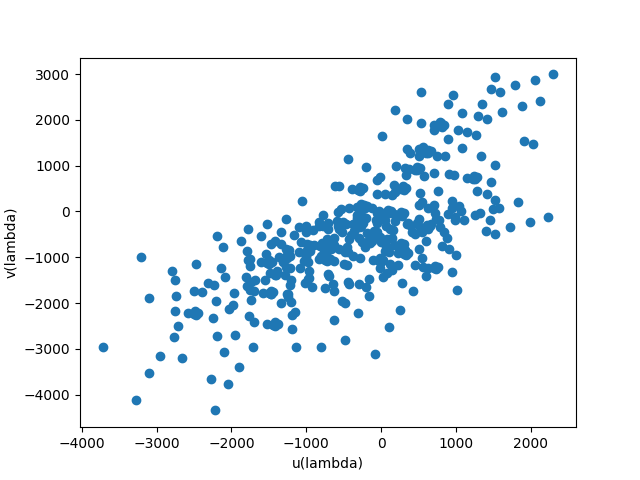

Text(0, 0.5, 'v(lambda)')

In [9]:
figure()
scatter(uvws[:,0,0],uvws[:,1,0])
xlabel('u(lambda)')
ylabel('v(lambda)')


<IPython.core.display.Javascript object>


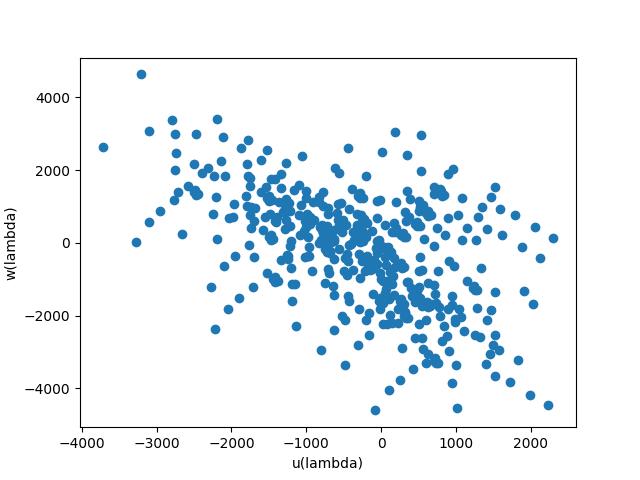

Text(0, 0.5, 'w(lambda)')

In [10]:
figure()
scatter(uvws[:,0,0],uvws[:,2,0])
xlabel('u(lambda)')
ylabel('w(lambda)')

<IPython.core.display.Javascript object>


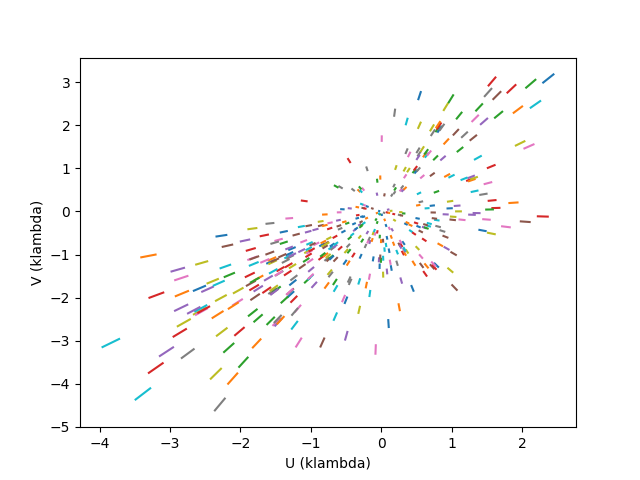

In [11]:
figure()
f.plot_baselines()

<IPython.core.display.Javascript object>


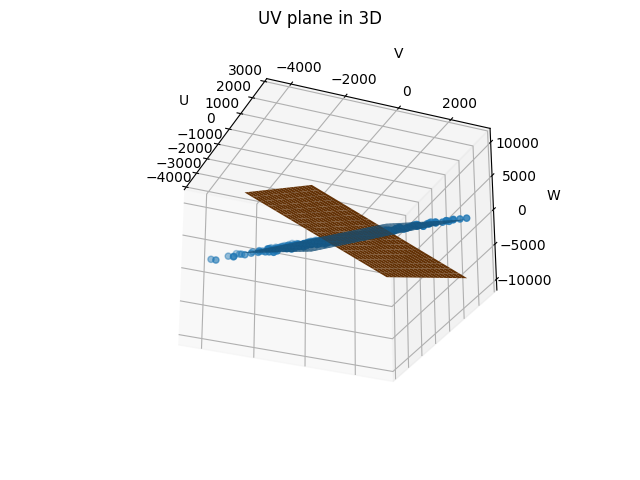

Text(0.5, 0.98, 'UV plane in 3D')

In [87]:
fig = figure()

ugrid = np.arange(-3000,3000,300)
vgrid= np.arange(-3000,3000,300)
U, V = np.meshgrid(ugrid,vgrid)
W = plan.craco_wcs.a*U + plan.craco_wcs.b*V
wprime = plan.craco_wcs.a*uvws[:,0,0] + plan.craco_wcs.b*uvws[:,1,0]

ax = fig.add_subplot(projection='3d')
ax.scatter(uvws[:,0,0],uvws[:,1,0],uvws[:,2,0])
ax.plot_surface(U,V,W)
ax.plot_surface(U,V,plan.craco_wcs.a*U - plan.craco_wcs.b*V)
#ax.scatter(uvws[:,0,0],uvws[:,1,0],uvws[:,2,0]-wprime)

ax.set_xlabel('U')
ax.set_ylabel('V')
ax.set_zlabel('W')
fig.suptitle('UV plane in 3D')

<IPython.core.display.Javascript object>


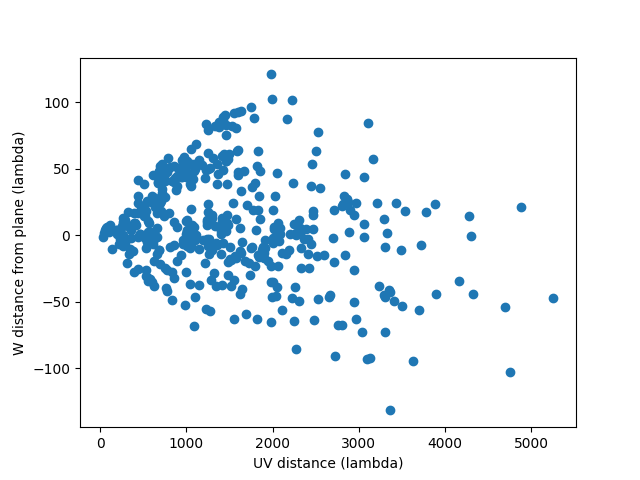

Text(0.5, 0, 'UV distance (lambda)')

In [90]:
figure()
plot(np.sqrt(uvws[:,0,0]**2 + uvws[:,1,0]**2), uvws[:,2,0]-wprime,'o')
ylabel('W distance from plane (lambda)')
xlabel('UV distance (lambda)')

In [13]:
plan.craco_wcs.a

-1.9725608379728206

In [14]:
plan.craco_wcs.b

1.5582007215728193

In [15]:
ax.plot_surface?


In [16]:
f.baselines.keys()


dict_keys([258.0, 259.0, 260.0, 261.0, 262.0, 263.0, 264.0, 265.0, 266.0, 267.0, 268.0, 269.0, 270.0, 271.0, 272.0, 273.0, 274.0, 275.0, 276.0, 277.0, 278.0, 279.0, 280.0, 281.0, 282.0, 283.0, 284.0, 285.0, 286.0, 515.0, 516.0, 517.0, 518.0, 519.0, 520.0, 521.0, 522.0, 523.0, 524.0, 525.0, 526.0, 527.0, 528.0, 529.0, 530.0, 531.0, 532.0, 533.0, 534.0, 535.0, 536.0, 537.0, 538.0, 539.0, 540.0, 541.0, 542.0, 772.0, 773.0, 774.0, 775.0, 776.0, 777.0, 778.0, 779.0, 780.0, 781.0, 782.0, 783.0, 784.0, 785.0, 786.0, 787.0, 788.0, 789.0, 790.0, 791.0, 792.0, 793.0, 794.0, 795.0, 796.0, 797.0, 798.0, 1029.0, 1030.0, 1031.0, 1032.0, 1033.0, 1034.0, 1035.0, 1036.0, 1037.0, 1038.0, 1039.0, 1040.0, 1041.0, 1042.0, 1043.0, 1044.0, 1045.0, 1046.0, 1047.0, 1048.0, 1049.0, 1050.0, 1051.0, 1052.0, 1053.0, 1054.0, 1286.0, 1287.0, 1288.0, 1289.0, 1290.0, 1291.0, 1292.0, 1293.0, 1294.0, 1295.0, 1296.0, 1297.0, 1298.0, 1299.0, 1300.0, 1301.0, 1302.0, 1303.0, 1304.0, 1305.0, 1306.0, 1307.0, 1308.0, 1309.0, 1

In [17]:
d = f.baselines[258.0]
blid = d['BASELINE']
blid

258.0

In [18]:
u,v,w = d['UU'],d['VV'],d['WW']
freqs = plan.freqs
ulam, vlam, wlam = u*freqs, v*freqs, w*freqs


In [19]:
idx = np.where(plan.baseline_order == blid)[0][0]
idx

0

In [20]:
vissim[idx,:].shape

(48,)

In [21]:
vissim.shape

(435, 48)

In [22]:
d.data.shape

(1, 1, 1, 48, 1, 3)

In [23]:
f.hdulist[0].data['DATA'].shape

(5898060, 1, 1, 1, 48, 1, 3)

In [24]:
if d.data.ndim == 6:
    visc = d.data[0, 0, 0,:,0,0] + 1j*d.data[0, 0,0,:,0,1]
else:
    visc = d.data[0,0,:,0,0] + 1j*d.data[0,0,:,0,1]
    
visdata = f.hdulist[0].data['DATA']
if visdata.ndim == 7:
    allvis = visdata[:,0, 0,0,:,0,0] + 1j*visdata[:,0,0,0,:,0,1]
else:
    allvis = visdata[:, 0,0,:,0,0] + 1j*visdata[:,0,0,:,0,1]


In [25]:
allvis.shape

(5898060, 48)

In [26]:
np.all(f.hdulist[0].data['BASELINE'] == plan.baseline_order)

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [27]:
#alldata = f.hdulist[0].data['DATA'][:,0,0,:,0,0] + 1j*f.hdulist[0].data['DATA'][:,0,0,:,0,1]
nbl = len(plan.baseline_order)
nchan=allvis.shape[1]
alldata = np.zeros((nbl, nchan), dtype=np.complex64)
blids = f.hdulist[0].data['BASELINE']
for i, ibl in enumerate(plan.baseline_order):
    idx = np.where(blids == ibl)[0][0]
    alldata[i, :] = allvis[idx, :]



In [28]:
blid = f.hdulist[0].data['BASELINE'][0]
blid

257.0

In [29]:
alldata.shape

(435, 48)

In [30]:
def grid(plan, din, uvcell, npix):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
        
    g = np.zeros((npix,npix), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        #w = uvw_sec[2]*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        pivot = npix // 2
        upix = np.round(u/uvcell[0] ).astype(int)
        vpix = np.round(v/uvcell[1] ).astype(int)
        for ichan, (up,vp) in enumerate(zip(upix,vpix)):
            g[pivot+vp,pivot+up] += din[ibl,ichan]
            g[pivot-vp,pivot-up] += np.conj(din[ibl,ichan])
        
        
    return g

def doimage(g):
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(g)))

# Does my point source function and miriad agree?


<IPython.core.display.Javascript object>


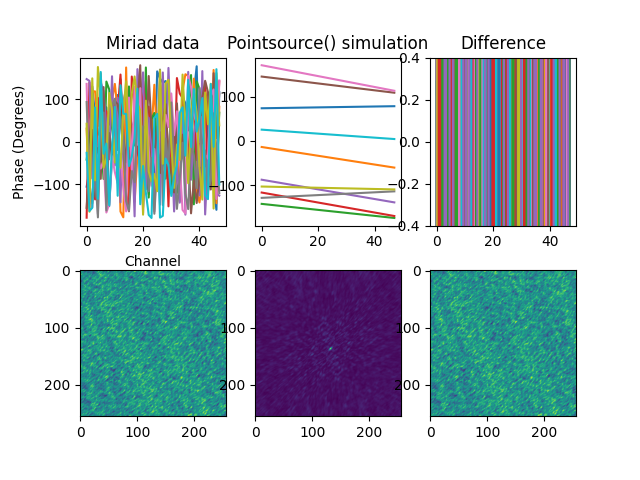

In [31]:

nant = 20
nbl = 20*19//2
fig,ax = subplots(2,3)
mir_img = doimage(grid(plan, alldata, plan.uvcell, plan.npix)).real
pointsource_img = doimage(grid(plan, vissim, plan.uvcell, plan.npix)).real

ax[0,0].plot(np.degrees(np.angle(alldata[-10:,:].T)))
ax[0,0].set_ylabel('Phase (Degrees)')
ax[0,0].set_xlabel('Channel')
ax[0,1].plot(np.degrees(np.angle(vissim[-10:].T)))
ax[0,0].set_title('Miriad data')
ax[0,1].set_title('Pointsource() simulation')
ax[0,2].plot(np.degrees(np.angle(alldata.T) - np.angle(vissim.T)))
ax[0,2].set_ylim(-0.4,0.4)
ax[0,2].set_title('Difference')

ax[1,0].imshow(mir_img)
ax[1,1].imshow(pointsource_img)
ax[1,2].imshow(mir_img - pointsource_img)



In [32]:
plan.freqs[0]

744000000.0

In [33]:
f.hdulist[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    7                                                  
NAXIS1  =                    0 / Random axis group                              
NAXIS2  =                    3                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                   48                                                  
NAXIS5  =                    1                                                  
NAXIS6  =                    1                                                  
NAXIS7  =                    1                                                  
EXTEND  =                    T / Tables will follow                             
BLOCKED =                    T / File may be blocked                            
GROUPS  =                   

In [34]:
! $MIRBIN/prthd in=/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits.mir/


prthd: Revision 1.10, 2012/03/02 06:13:02 UTC

****************************************************************
Filename: /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits.mir/
Telescope: ASKAP
Object: frb_d0_t0_a1_sninf_lm100200.fits.mir
First time: 20JUN10:00:00:00.0
Number of antennae: 20
Polarisations Present: I
Type of correlations present: crosscorrelation
----------------------------------------------------------------
Spectral Correlations:
  Spectrum  Channels  Freq(chan=1)  Increment  Restfreq
      1        256       0.73550     0.001000   0.86300 GHz
  Total number of correlations: 826880
  Correlations are stored in 16-bit form

Continuum (wide) correlations:
  Corr No.  Frequency Bandwidth
      1       0.863    0.256000  GHz
  Total number of correlations: 3230
----------------------------------------------------------------
J2000    Source RA: 00:00:00.000  Dec: -30:00:00.00
Apparent Source RA: 00:00:00.000  Dec: -30:00:00.00

Hi

In [35]:
# Miriad says the UVFITS file frequency channel 1 is 0.73550
# but the plan says
plan.freqs[0]

744000000.0

In [36]:
f.channel_frequencies[0]

743990740.7407407

In [37]:
from craft import craco
craco.get_freqs(f.hdulist)[0]

743990740.7407407

In [38]:
f.hdulist[0].header['CRPIX4']

24.5

In [39]:
f.hdulist[0].header['CRVAL4']

767490740.7407405

In [40]:
f.hdulist[0].header['CDELT4']

999999.9999999962

In [41]:
from astropy import wcs
w = wcs.WCS(f.hdulist[0].header)

In [42]:
w

WCS Keywords

Number of WCS axes: 7
CTYPE : ''  'COMPLEX'  'STOKES'  'FREQ'  'IF'  'RA'  'DEC'  
CRVAL : 0.0  1.0  -5.0  767490740.7407405  1.0  1.0  1.0  
CRPIX : 0.0  1.0  1.0  24.5  1.0  1.0  1.0  
NAXIS : 0  3  1  48  1  1  1

In [43]:
#w.pixel_to_world(0,0,0,0,0,0)[3]

<IPython.core.display.Javascript object>


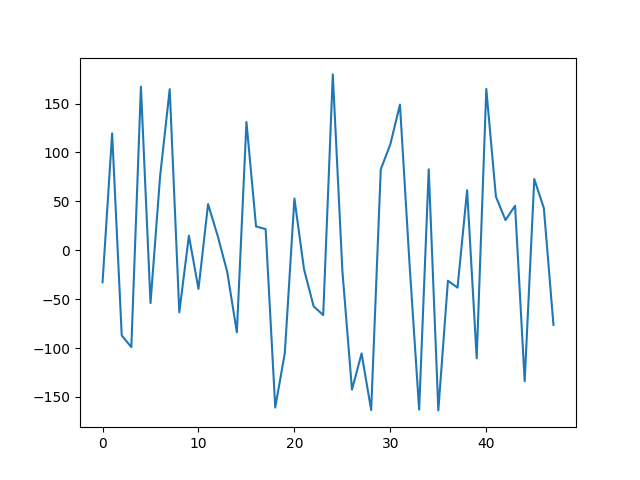

In [44]:
figure()
plot(np.degrees(np.angle(visc)))
#plot(np.degrees(np.angle(np.conj(vissim[idx,:]))),'x')

<IPython.core.display.Javascript object>


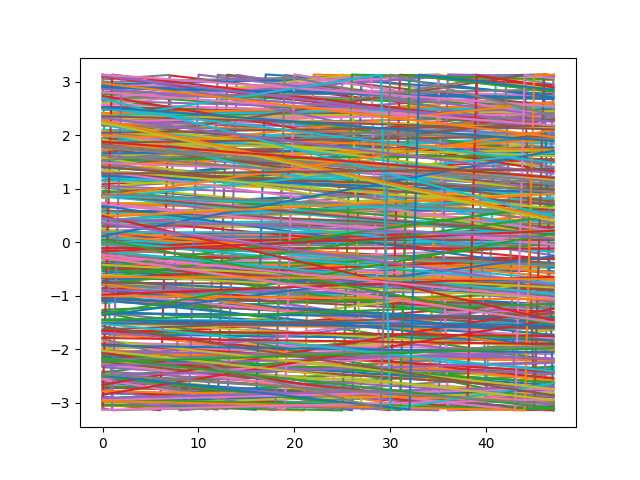

In [45]:
figure()
_ = plot(np.angle(vissim).T)

In [46]:
plan.uvcell

(32.46936663907381, 37.88180458689102)

lm=[0.01047178 0.012217  ]


<IPython.core.display.Javascript object>


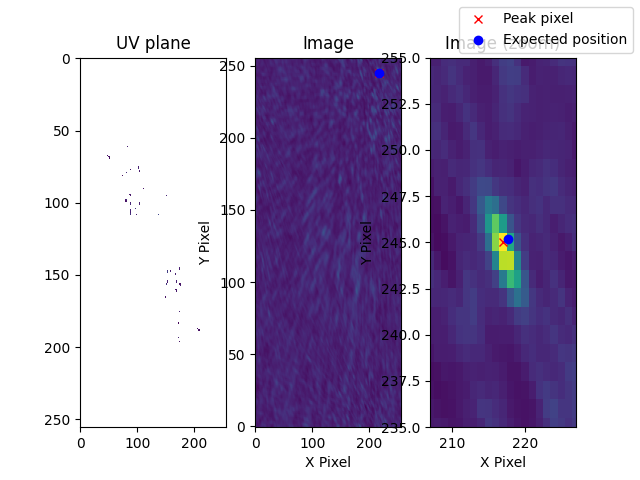

maxpix (245, 217)


In [47]:
# use plan cell size
uvcell = plan.uvcell

# use plan npix
npix=plan.npix

#    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
psi = Angle('0.6d') # offset degrees - RA direction
theta = Angle('0.7d') # offset degrees - dec direction
expected_dec = plan.phase_center.dec + theta # not sure why I need a negative here
# RA needs to be decremented by source cos dec
expected_ra = np.degrees(plan.phase_center.ra.rad - psi.rad/np.cos(expected_dec.rad))
expected_pos = SkyCoord(expected_ra, expected_dec, unit='deg')
# What did I expect the pixel location to be, given the expected position?
expected_pixel = plan.wcs.world_to_pixel(expected_pos)

lm = np.sin([psi.rad, theta.rad])
print(f'lm={lm}')
#lm=(0.01,0.02)
#lm = (0,0)
#lm = (0,0)
peak = 97280.0
vissim = pointsource(1, lm, plan)

fig,ax = subplots(1,3)
g = grid(plan, vissim, uvcell, npix)/np.prod(vissim.shape)/2 # Scales image to 1 for phase center
img = doimage(g)
gimg = abs(g)
gimg[gimg==0] = np.nan
maxpix = np.unravel_index(np.argmax(img.real), img.shape)
print('maxpix', maxpix)
ymax,xmax = maxpix
extents = (xmax -10, xmax+10, ymax-10, ymax+10)
#xtents=None
ax[0].imshow(gimg, aspect='auto')
ax[0].set_title("UV plane")

ax[1].imshow(img.real,aspect='auto', origin='lower')
ax[1].plot(xmax,ymax, 'rx')
ax[1].plot(expected_pixel[0], expected_pixel[1], 'bo')
ax[1].set_xlabel('X Pixel')
ax[1].set_ylabel('Y Pixel')
ax[1].set_title("Image")


ax[2].imshow(img.real,aspect='auto', origin='lower')
line1, = ax[2].plot(xmax,ymax, 'rx')
# (Because matplotlib pixels are centered on 0, we have to add 0.5 pixels) to get them to line up
# if you set the position to 0,0
line2, = ax[2].plot(expected_pixel[0]+0.5, expected_pixel[1]+0.5, 'bo') 
ax[2].set_xlabel('X Pixel')
ax[2].set_ylabel('Y Pixel')
ax[2].set_xlim(xmax-10,xmax+10)
ax[2].set_ylim(ymax-10,ymax+10)
ax[2].set_title("Image (zoom)")

figlegend((line1,line2),('Peak pixel','Expected position'))
        

<IPython.core.display.Javascript object>


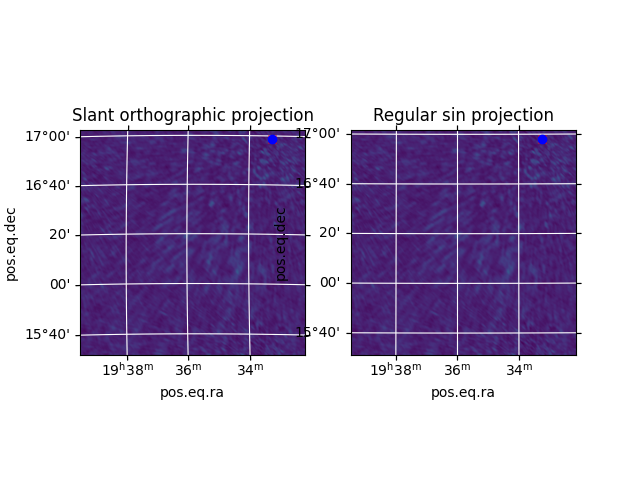

Text(0.5, 1.0, 'Regular sin projection')

In [48]:
from astropy.wcs import WCS
mywcs = WCS(naxis=2)
mywcs.wcs.crpix = [npix/2+1,npix/2+1] # honestly, I dont' understand if we need to +0.5 or not, or 1. 
mywcs.wcs.crval = [plan.phase_center.ra.deg, plan.phase_center.dec.deg]
mywcs.wcs.ctype = ['RA---SIN','DEC--SIN']
mywcs.wcs.cunit = ['deg','deg']
mywcs.wcs.cdelt = [-plan.lmcell[0].deg, plan.lmcell[1].deg]
import matplotlib.pyplot as plt
figure()

plt.subplot(1,2,1, projection=plan.wcs)
plt.imshow(img.real)
plt.grid(color='white', ls='solid')
plt.plot(xmax,ymax, 'rx')
plt.plot(expected_pixel[0], expected_pixel[1], 'bo')
plt.title('Slant orthographic projection')

plt.subplot(1,2,2,projection=mywcs)
plt.imshow(img.real)
plt.grid(color='white', ls='solid')
plt.plot(xmax,ymax, 'rx')
plt.plot(expected_pixel[0], expected_pixel[1], 'bo')
plt.title('Regular sin projection')


In [49]:
plan.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 293.94875  16.277786111111123  
CRPIX : 129.0  129.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.006893009069466779  0.005908156730221551  
NAXIS : 0  0

In [50]:
# there's some extra stuff in GETPV - that Steve Told me to put in to make it a slant orthographic projection
# see Ord et al. 2020 I t
plan.wcs.wcs.get_pv()

[(2, 1, -1.9725608379728206), (2, 2, -1.5582007215728193)]

In [51]:
# CRPIX is 128.5,128.5, but if you put do pixel_to_world(127.5,127.5) you get CRVAL back
# So there's a +-1 added because of the FITS convention. SIGH
plan.wcs.pixel_to_world(127.5,127.5)

<SkyCoord (ICRS): (ra, dec) in deg
    (293.95234075, 16.27483228)>

In [52]:
# similarly, wth the WCS as it stands, if you put in the phase center, what do you get?
# you get 127.5, 17.5
plan.wcs.world_to_pixel(plan.phase_center)

(array(128.), array(128.))

In [53]:
wcs_pos = plan.wcs.pixel_to_world(xmax-1,ymax-1) 
wcs_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (293.32957545, 16.97362246)>

In [54]:
expected_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (293.32140926, 16.97778611)>

In [55]:
ra_err = expected_pos.ra - wcs_pos.ra
ra_err

<Angle -0.00816619 deg>

In [56]:
dec_err = expected_pos.dec - wcs_pos.dec
dec_err

<Angle 0.00416366 deg>

In [57]:
# image resolution
plan.lmcell.arcsec

array([24.81483265, 21.26936423])

In [58]:
plan.wcs.world_to_pixel(expected_pos)

(array(217.16893258), array(244.67383881))

In [59]:
xmax, ymax

(217, 245)

In [60]:
# teh flat WCS is worse than plan.wcs, ish.
mywcs.world_to_pixel(expected_pos)

(array(215.04297435), array(246.63315516))

# Sweep in RA/Dec

In [61]:
#    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
expected_pixels = []
expected_pixels_flat = []
max_value = []

actual_pixels = []
angrange = np.arange(-0.7,0.7,0.1)
for psi in angrange:
    expected_pixels.append([])
    actual_pixels.append([]) 
    expected_pixels_flat.append([])
    max_value.append([])
    for theta in angrange:        
        psi = Angle(psi, unit='deg') # offset degrees - RA direction
        theta = Angle(theta,unit='deg') # offset degrees - dec direction
        expected_dec = plan.phase_center.dec + theta # not sure why I need a negative here
        expected_ra = np.degrees(plan.phase_center.ra.rad - psi.rad/np.cos(expected_dec.rad))
        expected_pos = SkyCoord(expected_ra, expected_dec, unit='deg')
        expected_pixel = plan.wcs.world_to_pixel(expected_pos)
        expected_pixel2 = mywcs.world_to_pixel(expected_pos)


        lm = np.sin([psi.rad, theta.rad])
        vissim = pointsource(1, lm, plan)
        g = grid(plan, vissim, uvcell, npix)/np.prod(vissim.shape)/2 # Scales image to 1 for phase center
        img = doimage(g)
        maxpix = np.unravel_index(np.argmax(img.real), img.shape)
        actual_pixels[-1].append(maxpix)
        expected_pixels[-1].append(expected_pixel)
        expected_pixels_flat[-1].append(expected_pixel2)
        max_value[-1].append(img.real.max())
        


In [62]:
expected_pixels = np.array(expected_pixels)
expected_pixels_flat = np.array(expected_pixels_flat)

actual_pixels = np.array(actual_pixels)

In [63]:
expected_pixels.shape

(14, 14, 2)

In [64]:
actual_pixels.shape

(14, 14, 2)

In [65]:
expected_pixels[0,0,:]

array([28.89361011,  7.48171984])

In [66]:
actual_pixels[0,0,:] # is transposed because of how unravel index works

array([ 7, 29])

<IPython.core.display.Javascript object>


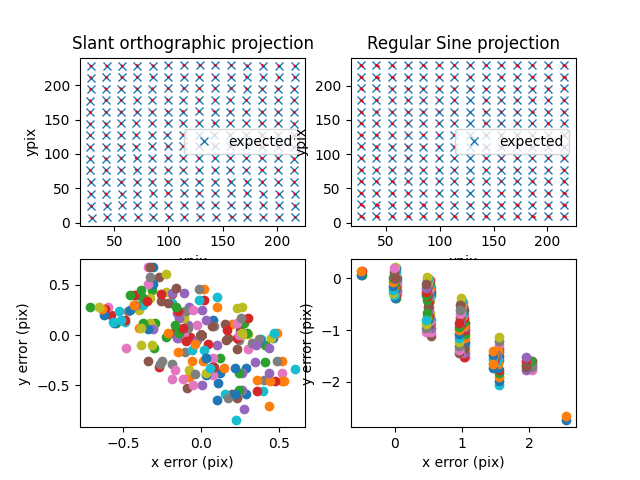

Text(0.5, 1.0, 'Regular Sine projection')

In [67]:

def plot_diff(ax, expected_pixels, actual_pixels):
    ax[0].plot(expected_pixels[...,0].flatten(), expected_pixels[...,1].flatten(), 'x', label='expected')
    for i in range(np.array(actual_pixels.shape[0:2]).prod()): 
        x1 = expected_pixels[...,0].flatten()[i]
        y1 = expected_pixels[...,1].flatten()[i]
        x2 = actual_pixels[...,1].flatten()[i]
        y2 = actual_pixels[...,0].flatten()[i]
        ax[0].plot([x1,x2],[y1,y2],'r')
        ax[1].plot([0,x2-x1],[0,y2-y1],'o')
        
        
    ax[0].set_xlabel('xpix')
    ax[0].set_ylabel('ypix')
    ax[1].set_xlabel('x error (pix)')
    ax[1].set_ylabel('y error (pix)')
    ax[0].legend()


fig, ax = subplots(2,2)
plot_diff(ax[:,0], expected_pixels, actual_pixels)
plot_diff(ax[:,1], expected_pixels_flat, actual_pixels)
ax[0,0].set_title('Slant orthographic projection')
ax[0,1].set_title('Regular Sine projection')



<IPython.core.display.Javascript object>


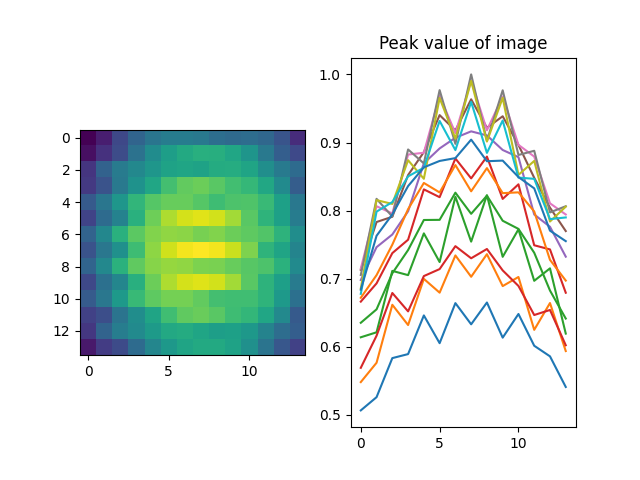

Text(0.5, 1.0, 'Peak value of image')

In [68]:
fig, ax = subplots(1,2)
ax[0].imshow(max_value)
ax[1].plot(max_value)
title('Peak value of image')

<IPython.core.display.Javascript object>


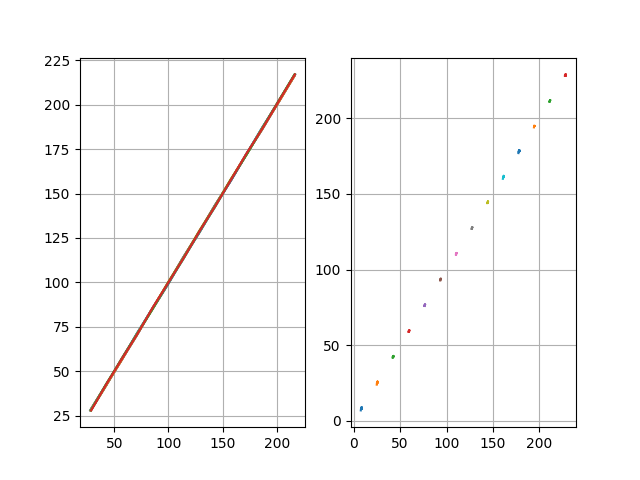

In [69]:
fig,ax = subplots(1,2)
ax[0].plot(expected_pixels[...,0],actual_pixels[...,1])
ax[1].plot(expected_pixels[...,1],actual_pixels[...,0])
ax[0].grid(True)
ax[1].grid(True)


# Doing something else - check what changing cell size does to peak value

In [70]:


for c in (2,5,10,15,20,30,40):
    for npix in (256,512,1024,2048,4096):
        uvcell=(c,c)
        try:
            g = grid(plan, vissim, uvcell, npix)
            img = doimage(g)
            print(f'c={c} npix={npix} max={img.real.max()/peak}')
        except:
            print(f'Couldnt grid c={c} npix={npix}')
        

Couldnt grid c=2 npix=256
Couldnt grid c=2 npix=512
Couldnt grid c=2 npix=1024
Couldnt grid c=2 npix=2048
Couldnt grid c=2 npix=4096
Couldnt grid c=5 npix=256
Couldnt grid c=5 npix=512
Couldnt grid c=5 npix=1024
c=5 npix=2048 max=0.40914534691654325
c=5 npix=4096 max=0.4242821024121902
Couldnt grid c=10 npix=256
Couldnt grid c=10 npix=512
c=10 npix=1024 max=0.39825161252676666
c=10 npix=2048 max=0.4132251168889052
c=10 npix=4096 max=0.4132251168889052
Couldnt grid c=15 npix=256
Couldnt grid c=15 npix=512
c=15 npix=1024 max=0.3883536467929009
c=15 npix=2048 max=0.39388701770267864
c=15 npix=4096 max=0.3951467039437786
Couldnt grid c=20 npix=256
c=20 npix=512 max=0.3548670421615227
c=20 npix=1024 max=0.3694326631846267
c=20 npix=2048 max=0.3694326631846267
c=20 npix=4096 max=0.3702024622746345
Couldnt grid c=30 npix=256
c=30 npix=512 max=0.2986436026587851
c=30 npix=1024 max=0.30347244937197526
c=30 npix=2048 max=0.3041716116710854
c=30 npix=4096 max=0.3046046506119211
c=40 npix=256 max=

In [71]:
sum(abs(vissim))

20880.0

In [72]:
np.prod(vissim.shape)

20880

In [73]:
def degrid(plan, lm, uvcell):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    l,m = lm
        
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        w = uvw_sec[2]*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if uvcell is not None:
            u = np.round(u/uvcell[0])*uvcell[0]
            v = np.round(v/uvcell[1])*uvcell[1]
            
        devis = np.exp(-2j*np.pi*(u*l + v*m + 0*w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        dout[ibl,:] = devis
    return dout

vissimdg = degrid(plan,lm,uvcell=None)
print(np.sum(np.conj(vissimdg)*vissim)/np.prod(vissim.shape))

(-0.010259540601708424+0.010339564473236201j)


<IPython.core.display.Javascript object>


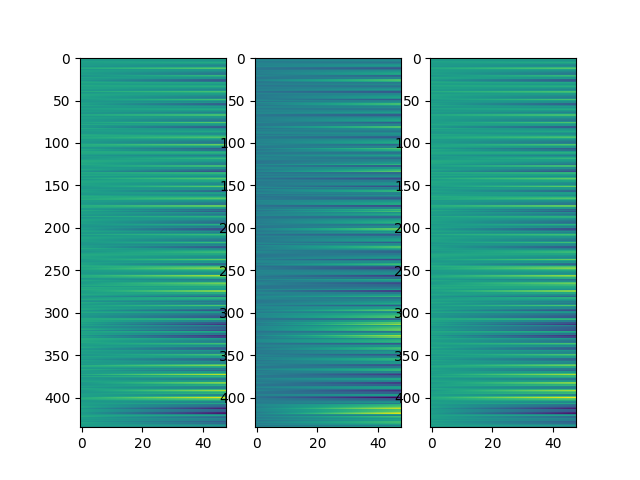

In [74]:
def myang(d):
    return np.degrees(np.unwrap(np.angle(d)))
fig,ax = subplots(1,3)
ax[0].imshow(myang(vissim), aspect='auto')
ax[1].imshow(myang(vissimdg), aspect='auto')
ax[2].imshow(myang(vissim) - myang(vissimdg), aspect='auto')


<IPython.core.display.Javascript object>


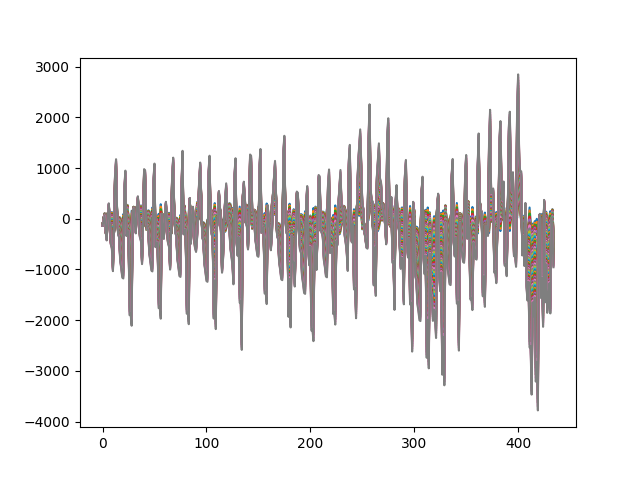

In [75]:
figure()
x = myang(vissim) - myang(vissimdg)
plot(x)

In [76]:
r = plan.fdmt_plan.runs[100]
r

ncells=8 fch1=743990740.7407407 chan_start=0 total_overlap=56

In [77]:
r.cells

[Cell blid=798.0 chan=16-22 freq=759990740.740741-765990740.740741 uvpix=(179, 196) upper_idx=13607 uvpix_upper=(77, 60),
 Cell blid=796.0 chan=15-21 freq=758990740.740741-764990740.740741 uvpix=(212, 190) upper_idx=30707 uvpix_upper=(212, 190),
 Cell blid=792.0 chan=0-6 freq=743990740.740741-749990740.740741 uvpix=(26, 50) upper_idx=31645 uvpix_upper=(230, 206),
 Cell blid=791.0 chan=0-6 freq=743990740.740741-749990740.740741 uvpix=(20, 35) upper_idx=32281 uvpix_upper=(236, 221),
 Cell blid=790.0 chan=0-6 freq=743990740.740741-749990740.740741 uvpix=(211, 227) upper_idx=7034 uvpix_upper=(45, 29),
 Cell blid=780.0 chan=0-6 freq=743990740.740741-749990740.740741 uvpix=(233, 237) upper_idx=4697 uvpix_upper=(23, 19),
 Cell blid=542.0 chan=25-31 freq=768990740.740741-774990740.740741 uvpix=(177, 194) upper_idx=13998 uvpix_upper=(79, 62),
 Cell blid=531.0 chan=4-10 freq=747990740.740741-753990740.740741 uvpix=(234, 227) upper_idx=32468 uvpix_upper=(234, 227)]